# **SPAM SMS DETECTION**

In [ ]:
import chardet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset and Preprocess

In [ ]:
with open('spam.csv', 'rb') as f:
    raw_data = f.read()
result = chardet.detect(raw_data)
encoding = result['encoding']

print(f"Detected encoding: {encoding}")

Detected encoding: Windows-1252


In [ ]:
data= pd.read_csv("spam.csv", encoding="Windows-1252")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data.isnull().sum()

,0
v1,0
v2,0
Unnamed: 2,5522
Unnamed: 3,5560
Unnamed: 4,5566


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
data = data.dropna(how="any", axis=1)
data.columns = ['target', 'message']

data.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


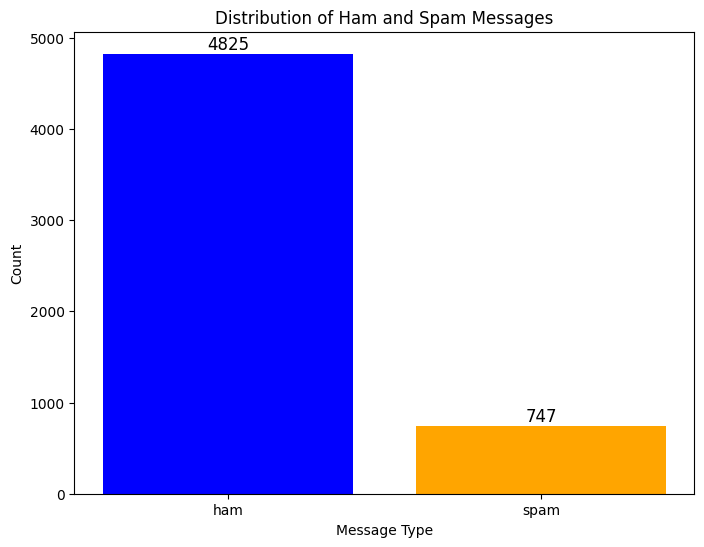

In [ ]:
plt.figure(figsize=(8, 6))
label_counts = data['target'].value_counts()
bars = plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center', fontsize=12)
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.title('Distribution of Ham and Spam Messages')
plt.show()

In [ ]:
data['length'] = data['message'].apply(lambda x: len(x.split(' ')))
ham_length = data[data['target'] == 'ham']['length']
spam_length = data[data['target'] == 'spam']['length']
print(f'Max length of ham message: {max(ham_length)}')
print(f'Max length of spam message: {max(spam_length)}')

Max length of ham message: 171
Max length of spam message: 35


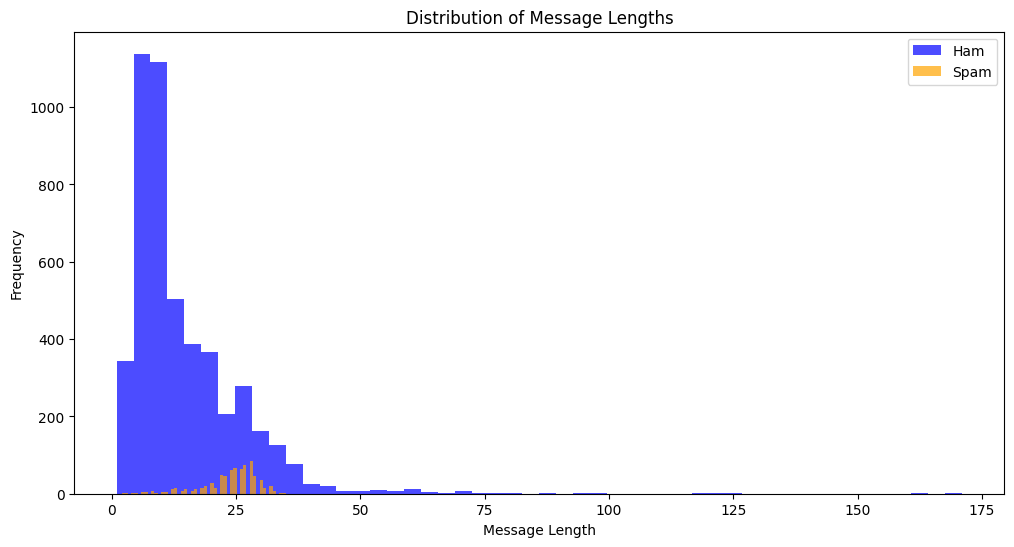

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(ham_length, bins=50, alpha=0.7, label='Ham', color='blue')
plt.hist(spam_length, bins=50, alpha=0.7, label='Spam', color='orange')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Cleaning the Data

In [ ]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
tokenizer = TreebankWordTokenizer()

def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = tokenizer.tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text
data['clean_mess'] = data['message'].apply(clean_text)

In [ ]:
data.head(5)

,target,message,length,clean_mess
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,6,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


Spliting the data and Vectorize

In [ ]:
X = data['clean_mess']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4179,) (4179,)
(1393,) (1393,)


In [ ]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

vocab_size = len(vectorizer.vocabulary_)
print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 6265


## Model Training and Predict

In [ ]:
modelLR = LogisticRegression(max_iter=1000).fit(X_train_vec, y_train)
y_pred_lr = modelLR.predict(X_test_vec)
accuracyLR = accuracy_score(y_test, y_pred_lr)
print('Accuracy:',accuracyLR)

Accuracy: 0.9490308686288585


In [ ]:
modelNB = MultinomialNB().fit(X_train_vec, y_train)
y_pred_nb = modelNB.predict(X_test_vec)
accuracyNB = accuracy_score(y_test, y_pred_nb)
print('Accuracy:',accuracyNB)

Accuracy: 0.9605168700646087


In [ ]:
modelSVC = SVC(kernel='linear', C=1.0, gamma='scale').fit(X_train_vec, y_train)
y_pred_svc = modelSVC.predict(X_test_vec)
accuracySVC = accuracy_score(y_test, y_pred_svc)
print('Accuracy:',accuracySVC)

Accuracy: 0.9748743718592965
